# Resnet152 model for Covid-19 classification

### Import packages

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from PIL import Image
import os
import matplotlib.pyplot as plt

from tqdm import tqdm
import time
import datetime


In [50]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed, 2))
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Dataset Parser

In [51]:
class COVIDDataset(Dataset):
    def __init__(self, data_file, transform=None):
        self.data = []
        self.transform = transform
        self.map = {'negative': 0, 'positive': 1}
        
        with open(data_file, 'r') as f:
            folder = os.path.splitext(data_file)[0]
            for line in f:
                patient_id, filename, label, data_source = line.strip().split(' ')
                image_path = os.path.join(folder, filename)
                self.data.append((image_path ,self.map[label]))
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

### Create Model

In [79]:
# Define the modified ResNet152 model
class ModifiedResNet152(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ModifiedResNet152, self).__init__()
        if pretrained:
            self.resnet = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        else:
            self.resnet = models.resnet152()
        self.resnet.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1024, out_features=num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x
    

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.
    correct = 0.
    total = 0.
    print(f'Loading # {len(train_loader)} datas')
    
    with tqdm(train_loader, unit='batch') as tepoch:
        for data, target in tepoch:
            tepoch.set_description(f"Training")
            data, target = data.to(device), target.to(device)

            # instead of  optimizer.zero_grad(), do it in forloop for more efficiency
            for param in model.parameters():
                param.grad = None

            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        
    acc = 100.*correct/total
    return train_loss, acc

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        with tqdm(val_loader, unit='batch') as tepoch:
            for data, target in tepoch:
                tepoch.set_description(f"Validating")
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
        
    acc = 100.*correct/total
    return val_loss, acc


### Begin Training process

In [53]:
# Set up hyperparameters for the model
# Set up hyperparameters and data loaders
# TUNABLE:
lr = 2e-4
# TUNABLE:
epochs = 22
# TUNABLE: original 64
batch_size = 16
# TUNABLE:
factor = 0.7
# TUNABLE:
patience = 5

num_classes = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# # Define the transformations to be applied to the data
target_size = 224
transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(target_size),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# create COVIDDataset object
# TUNABLE: --> can try different datasets
dataset = COVIDDataset('train.txt', transform=transform)

# get size of dataset
dataset_size = len(dataset)
print(f"Dataset size: {dataset_size}")

# split dataset into train and validation sets
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16,
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16,
                        shuffle=False)

# Define the model, loss function and optimizer
model = ModifiedResNet152(num_classes, pretrained=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=True)

# TUNABLE:
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()

# record training and validation losses and accuracies
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_acc = 0

start = time.time()
print(f"Began training for {epochs} epochs")
for epoch in range(epochs):
    print(f'Training (Epoch {epoch + 1})')
    torch.cuda.empty_cache()
    t0 = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    print("  * Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    t0 = time.time()
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print("  * Validation took: {:}".format(format_time(time.time() - t0)))

    # record training and validation losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'resnet152.pt')

print(f'Best validation accuracy: {best_acc:.2f}%')
print("Training complete in {}".format(format_time(time.time() - start)))

# # Use the pretrained Resnet152. Load the trained ResNet152 model
# model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
# model.fc = torch.nn.Sequential(
#     torch.nn.Linear(2048, 1024),
#     torch.nn.ReLU(),
#     # torch.nn.Linear(1024, 2),
#     torch.nn.LogSoftmax(dim=1)
# )

# # Set the model to evaluation mode
# model.eval()

# # Initialize an empty tensor to store the features for all images
# all_features = torch.empty(len(dataset), 1024)

# # Pass each batch of images through the model to obtain the features
# with torch.no_grad():
#     start_index = 0
#     for images, _ in tqdm(train_loader):
#         batch_size = images.shape[0]
#         features = model(images)
#         all_features[start_index:start_index+batch_size,:] = features
#         start_index += batch_size


Using device: cuda
Dataset size: 29986
Began training for 22 epochs
Epoch 1
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [11:42<00:00,  2.14batch/s]


  * Training epoch took: 0:11:42
  * Validation took: 0:02:09
Epoch 1, Train Loss: 142.6907, Train Acc: 96.49, Val Loss: 21.1527, Val Acc: 98.23
Epoch 2
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:07<00:00,  2.74batch/s]


  * Training epoch took: 0:09:07
  * Validation took: 0:01:32
Epoch 2, Train Loss: 73.8608, Train Acc: 98.19, Val Loss: 24.7275, Val Acc: 97.83
Epoch 3
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:23<00:00,  2.66batch/s]


  * Training epoch took: 0:09:23
  * Validation took: 0:01:35
Epoch 3, Train Loss: 68.5098, Train Acc: 98.37, Val Loss: 36.9841, Val Acc: 96.55
Epoch 4
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:27<00:00,  2.64batch/s]


  * Training epoch took: 0:09:27
  * Validation took: 0:01:34
Epoch 4, Train Loss: 55.1468, Train Acc: 98.66, Val Loss: 14.3568, Val Acc: 98.48
Epoch 5
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:16<00:00,  2.69batch/s]


  * Training epoch took: 0:09:16
  * Validation took: 0:01:33
Epoch 5, Train Loss: 42.9146, Train Acc: 98.95, Val Loss: 12.0639, Val Acc: 98.92
Epoch 6
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:58<00:00,  2.79batch/s]


  * Training epoch took: 0:08:58
  * Validation took: 0:01:32
Epoch 6, Train Loss: 36.1653, Train Acc: 99.19, Val Loss: 17.2514, Val Acc: 98.75
Epoch 7
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:57<00:00,  2.79batch/s]


  * Training epoch took: 0:08:57
  * Validation took: 0:01:33
Epoch 7, Train Loss: 28.7278, Train Acc: 99.35, Val Loss: 23.1919, Val Acc: 98.47
Epoch 8
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:54<00:00,  2.81batch/s]


  * Training epoch took: 0:08:54
  * Validation took: 0:01:32
Epoch 8, Train Loss: 21.3003, Train Acc: 99.45, Val Loss: 18.9906, Val Acc: 98.53
Epoch 9
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:55<00:00,  2.80batch/s]


  * Training epoch took: 0:08:55
  * Validation took: 0:01:32
Epoch 9, Train Loss: 28.2507, Train Acc: 99.38, Val Loss: 14.8384, Val Acc: 98.50
Epoch 10
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:57<00:00,  2.79batch/s]


  * Training epoch took: 0:08:57
  * Validation took: 0:01:33
Epoch 10, Train Loss: 16.5942, Train Acc: 99.66, Val Loss: 16.3345, Val Acc: 98.73
Epoch 11
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:57<00:00,  2.79batch/s]


  * Training epoch took: 0:08:57
  * Validation took: 0:01:32
Epoch 00011: reducing learning rate of group 0 to 1.4000e-04.
Epoch 11, Train Loss: 16.3808, Train Acc: 99.64, Val Loss: 15.5751, Val Acc: 98.65
Epoch 12
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:57<00:00,  2.79batch/s]


  * Training epoch took: 0:08:57
  * Validation took: 0:01:32
Epoch 12, Train Loss: 9.0715, Train Acc: 99.79, Val Loss: 44.2634, Val Acc: 98.37
Epoch 13
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:57<00:00,  2.79batch/s]


  * Training epoch took: 0:08:57
  * Validation took: 0:01:33
Epoch 13, Train Loss: 7.9807, Train Acc: 99.81, Val Loss: 27.7708, Val Acc: 98.40
Epoch 14
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:56<00:00,  2.80batch/s]


  * Training epoch took: 0:08:56
  * Validation took: 0:01:33
Epoch 14, Train Loss: 8.0881, Train Acc: 99.83, Val Loss: 19.3623, Val Acc: 98.92
Epoch 15
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [10:40<00:00,  2.34batch/s]


  * Training epoch took: 0:10:40
  * Validation took: 0:01:54
Epoch 15, Train Loss: 8.2417, Train Acc: 99.83, Val Loss: 18.6159, Val Acc: 98.98
Epoch 16
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [09:09<00:00,  2.73batch/s]


  * Training epoch took: 0:09:09
  * Validation took: 0:01:32
Epoch 16, Train Loss: 7.1898, Train Acc: 99.85, Val Loss: 19.2950, Val Acc: 98.85
Epoch 17
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:55<00:00,  2.80batch/s]


  * Training epoch took: 0:08:55
  * Validation took: 0:01:33
Epoch 00017: reducing learning rate of group 0 to 9.8000e-05.
Epoch 17, Train Loss: 7.0231, Train Acc: 99.87, Val Loss: 16.7615, Val Acc: 98.75
Epoch 18
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:54<00:00,  2.80batch/s]


  * Training epoch took: 0:08:54
  * Validation took: 0:01:31
Epoch 18, Train Loss: 2.7048, Train Acc: 99.93, Val Loss: 22.4822, Val Acc: 98.80
Epoch 19
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:55<00:00,  2.80batch/s]


  * Training epoch took: 0:08:55
  * Validation took: 0:01:34
Epoch 19, Train Loss: 5.5233, Train Acc: 99.87, Val Loss: 23.0846, Val Acc: 98.88
Epoch 20
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:55<00:00,  2.80batch/s]


  * Training epoch took: 0:08:55
  * Validation took: 0:01:32
Epoch 20, Train Loss: 1.3692, Train Acc: 99.96, Val Loss: 26.6251, Val Acc: 98.83
Epoch 21
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:53<00:00,  2.81batch/s]


  * Training epoch took: 0:08:53
  * Validation took: 0:01:32
Epoch 21, Train Loss: 2.4960, Train Acc: 99.95, Val Loss: 22.7361, Val Acc: 98.87
Epoch 22
Loading # 1500 datas


Training: 100%|██████████| 1500/1500 [08:54<00:00,  2.81batch/s]


  * Training epoch took: 0:08:54
  * Validation took: 0:01:33
Epoch 22, Train Loss: 4.0452, Train Acc: 99.93, Val Loss: 23.6788, Val Acc: 98.83
Best validation accuracy: 98.98%
Training complete in 3:57:56


### Plot the loss and accuracy

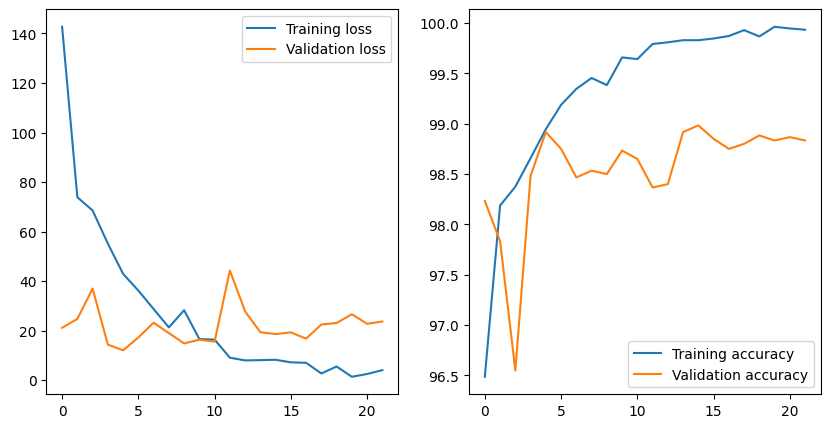

In [81]:
# plot training and validation losses and accuracies
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H%M%S")
# script_dir = os.path.dirname(__file__)
# plot_dir = os.path.join(script_dir, 'plots/')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.legend()
plt.savefig('./resnet_plots/' + f'loss_resnet152_{now}.png')
plt.show()

### Test the resnet model

In [78]:
# test data
test_dataset = COVIDDataset('test.txt', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# load best model
model.load_state_dict(torch.load('resnet152.pt'))

# evaluate model on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.2f}%')

Test loss: 0.9935, Test accuracy: 96.00%
